In [3]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  !pip install -q swig
  !pip install -q gymnasium[box2d]
else:
  %pip install -q -r requirements.txt

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import gymnasium as gym
import torch
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
import Agent
import QNetwork
from torchvision import models, transforms, utils

In [6]:
%matplotlib inline
from IPython import display

In [7]:
env = gym.make("CarRacing-v2",continuous=False, render_mode="rgb_array")
print(f"Observation space: {env.observation_space}")

Observation space: Box(0, 255, (96, 96, 3), uint8)


Here we can see that our observation has shape (96, 96, 3), which indicates that the image is what give us our state. We have a huge set of possible states that can be expressed by: $256^{96x96x3}$



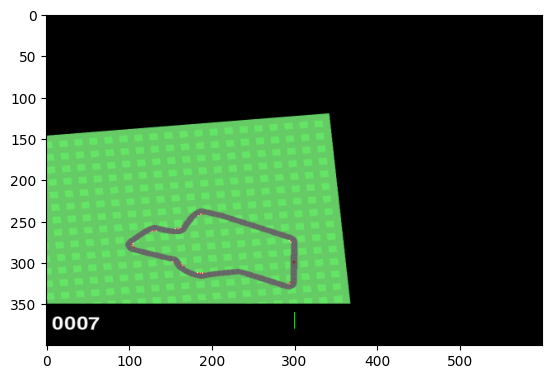

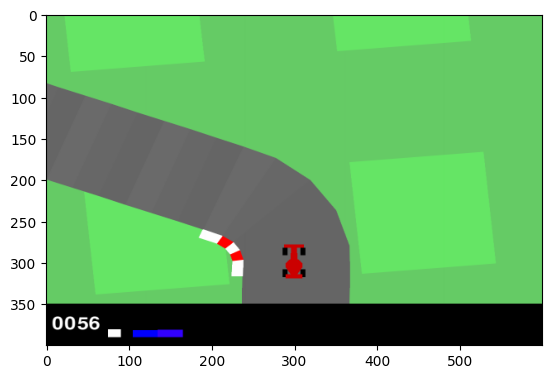

In [8]:
env.reset()
plt.imshow(PIL.Image.fromarray(env.render()))
plt.show()
for _ in range(100):
    env.step(np.array(3))
image = PIL.Image.fromarray(env.render())
plt.imshow(image)
plt.show()

In [9]:
env.action_space

Discrete(5)

We have 5 possible actions.

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Let's instantiate a QNetwork and see its structure.

In [15]:
QNet = QNetwork.QNetwork().to(device)
QNet

QNetwork(
  (conv1): Conv2d(3, 8, kernel_size=(4, 4), stride=(2, 2))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=5, bias=True)
)

## Resnet?

In [ ]:
model = models.resnet18(pretrained=True).to(device)
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import torch.nn as nn
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
print(conv_layers)

Total convolution layers: 17
[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(256

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0., std=1.)
])

In [ ]:
image = transform(image)
print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image = image.to(device)

Image shape before: torch.Size([3, 224, 224])
Image shape after: torch.Size([1, 3, 224, 224])


In [ ]:
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image).to(device)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

17
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 14, 14])


In [ ]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(14, 14)
(14, 14)
(14, 14)
(14, 14)


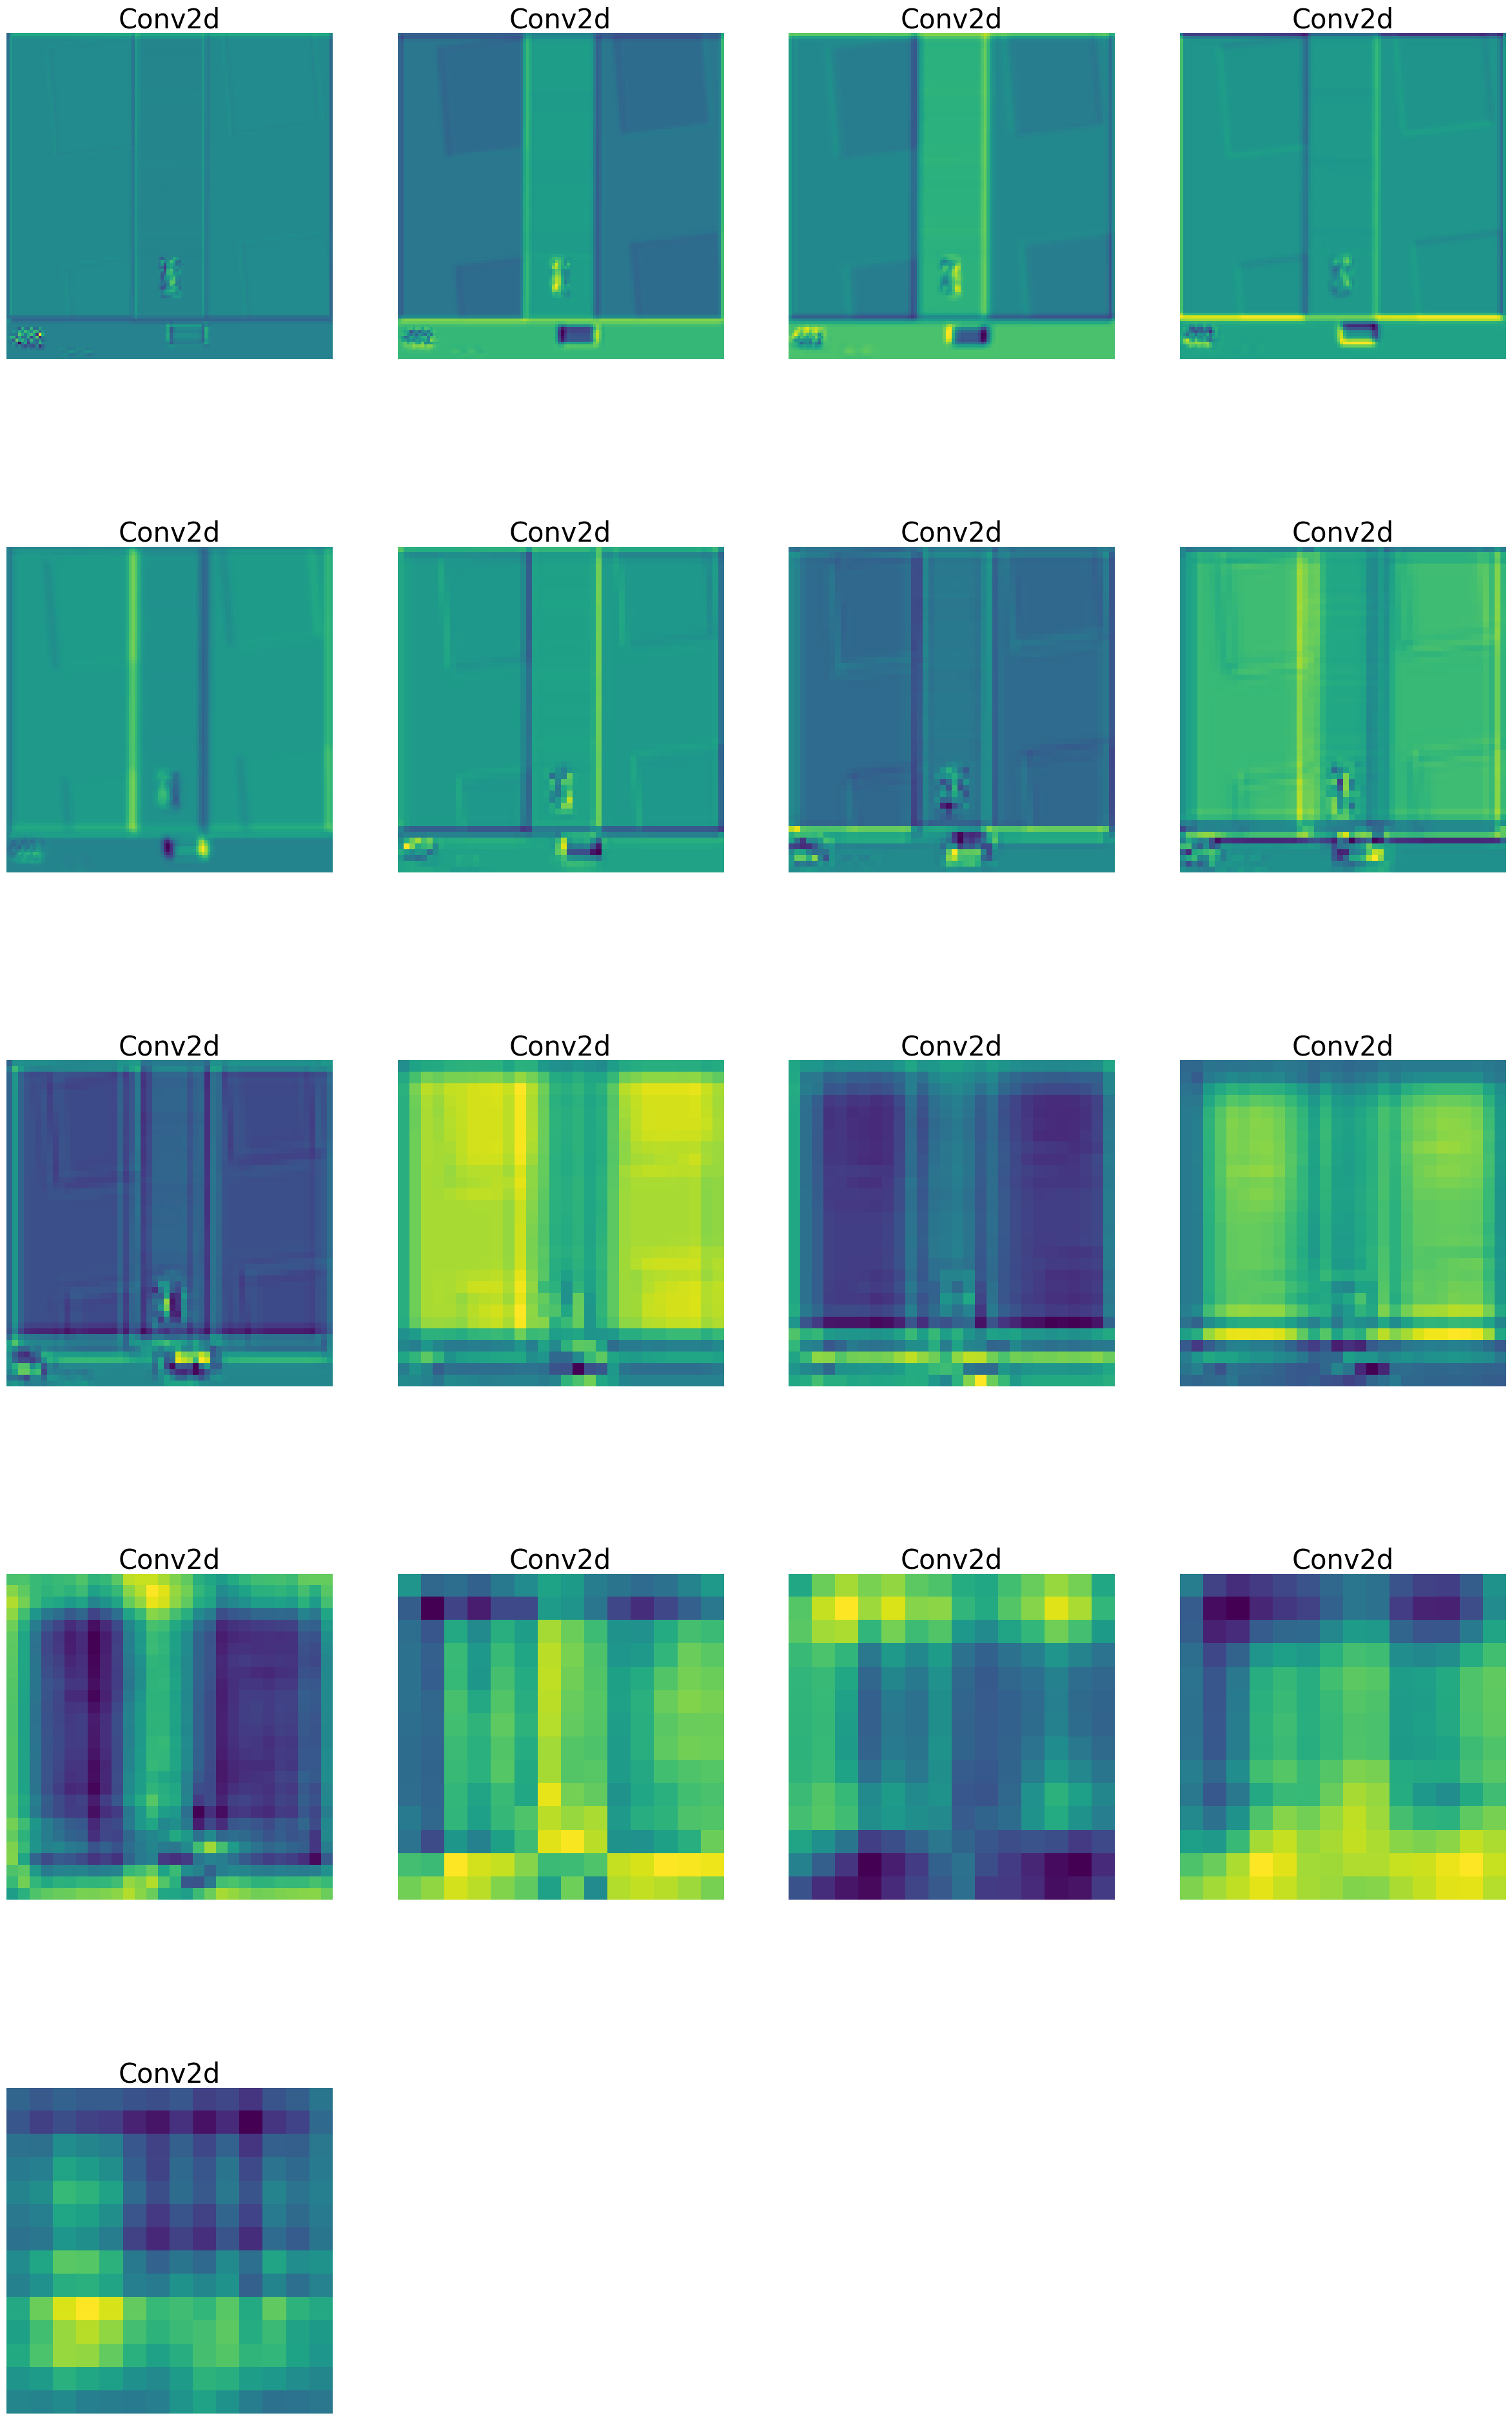

In [ ]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

In [ ]:
import Agent_Resnet
agent = Agent_Resnet.Agent()
rewards = []
total_episodes = 100
max_steps = 1000

for episode in range(total_episodes):
    state, _ = env.reset()
    cumulative_reward = 0

    for i in range(max_steps):
        action = agent.act(state)
        next_state, reward, done, _, _ = env.step(action)
        agent.step(state,action,reward,next_state,done)
        state = next_state
        cumulative_reward += reward
        if done:
            break

    rewards.append(cumulative_reward)
    print(f"Episode {episode}/{total_episodes}, Return = {cumulative_reward}, The epsilon now is : {agent.epsilon}")

Episode 0/1500, Return = -53.40501792114776, The epsilon now is : 1.0
Episode 1/1500, Return = -55.12820512820598, The epsilon now is : 1.0
Episode 2/1500, Return = -46.36015325670564, The epsilon now is : 0.9999
Episode 3/1500, Return = -56.36363636363719, The epsilon now is : 0.9752111619411448
Episode 4/1500, Return = -59.86622073578685, The epsilon now is : 0.9511319235669539
Episode 5/1500, Return = -55.32646048110048, The epsilon now is : 0.9276472330643509
Episode 6/1500, Return = -51.67286245353232, The epsilon now is : 0.9047424102692004
Episode 7/1500, Return = -47.955390334573245, The epsilon now is : 0.8824031374898074
Episode 8/1500, Return = -64.6302250803867, The epsilon now is : 0.8606154505570021
Episode 9/1500, Return = -60.12269938650389, The epsilon now is : 0.8393657300952052
Episode 10/1500, Return = -60.78431372549115, The epsilon now is : 0.8186406930090225
Episode 11/1500, Return = -43.26241134751839, The epsilon now is : 0.7984273841800505
Episode 12/1500, Ret

## QNetwork

In [16]:
agent = Agent.Agent()
rewards = []
total_episodes = 110
max_steps = 1000

for episode in range(total_episodes):
    state, _ = env.reset()
    cumulative_reward = 0

    for i in range(max_steps):
        action = agent.act(state)
        next_state, reward, done, _, _ = env.step(action)
        agent.step(state,action,reward,next_state,done)
        state = next_state
        cumulative_reward += reward
        if done:
            break

    rewards.append(cumulative_reward)
    print(f"Episode {episode}/{total_episodes}, Return = {cumulative_reward}, The epsilon now is : {agent.epsilon}")

Episode 0/110, Return = -57.317073170732584, The epsilon now is : 1.0
Episode 1/110, Return = -60.84337349397683, The epsilon now is : 1.0
Episode 2/110, Return = -52.70270270270351, The epsilon now is : 0.9999
Episode 3/110, Return = -54.063604240283425, The epsilon now is : 0.9752111619411448
Episode 4/110, Return = -47.36842105263223, The epsilon now is : 0.9511319235669539
Episode 5/110, Return = -51.89003436426198, The epsilon now is : 0.9276472330643509
Episode 6/110, Return = -26.070038910506227, The epsilon now is : 0.9047424102692004
Episode 7/110, Return = -38.52459016393519, The epsilon now is : 0.8824031374898074
Episode 8/110, Return = -46.54088050314538, The epsilon now is : 0.8606154505570021
Episode 9/110, Return = -48.27586206896618, The epsilon now is : 0.8393657300952052
Episode 10/110, Return = -44.805194805195555, The epsilon now is : 0.8186406930090225
Episode 11/110, Return = -48.55305466238008, The epsilon now is : 0.7984273841800505
Episode 12/110, Return = -41

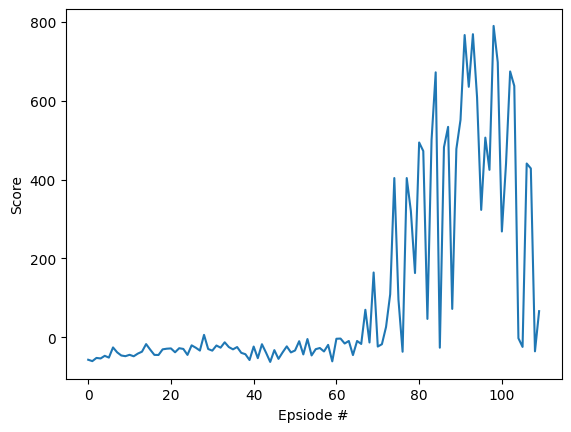

In [17]:
import matplotlib.pylab as plt

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(rewards)),rewards)
plt.ylabel('Score')
plt.xlabel('Epsiode #')
plt.show()

torch.save(agent.qnetwork_target.state_dict(), './weights.pt')

In [19]:
best_reward = 790

for episode in range(500):
    state, _ = env.reset()
    cumulative_reward = 0

    for i in range(max_steps):
        action = agent.act(state)
        next_state, reward, done, _, _ = env.step(action)
        agent.step(state,action,reward,next_state,done)
        state = next_state
        cumulative_reward += reward
        if done:
            break

        if cumulative_reward >= best_reward:
            best_reward = cumulative_reward
            torch.save(agent.qnetwork_target.state_dict(), './weights_best.pt')

    rewards.append(cumulative_reward)
    print(f"Episode {episode}/{total_episodes}, Return = {cumulative_reward}, The epsilon now is : {agent.epsilon}")

Episode 0/110, Return = 697.4683544303701, The epsilon now is : 0.07012100553296877
Episode 1/110, Return = 799.9999999999865, The epsilon now is : 0.06838962624491227
Episode 2/110, Return = 770.1754385964754, The epsilon now is : 0.06670099697471883
Episode 3/110, Return = 818.1494661921585, The epsilon now is : 0.06505406216856513
Episode 4/110, Return = 575.1592356687753, The epsilon now is : 0.0634477923356315
Episode 5/110, Return = 706.4516129032121, The epsilon now is : 0.06188118340457206
Episode 6/110, Return = 474.54545454544007, The epsilon now is : 0.060353256095875385
Episode 7/110, Return = 228.57142857142273, The epsilon now is : 0.058863055309721087
Episode 8/110, Return = 766.1971830985766, The epsilon now is : 0.057409649528951855
Episode 9/110, Return = 833.9933993399238, The epsilon now is : 0.055992130236786675
Episode 10/110, Return = 461.2244897959081, The epsilon now is : 0.05460961134891145
Episode 11/110, Return = 249.51456310678796, The epsilon now is : 0.05

KeyboardInterrupt: ignored

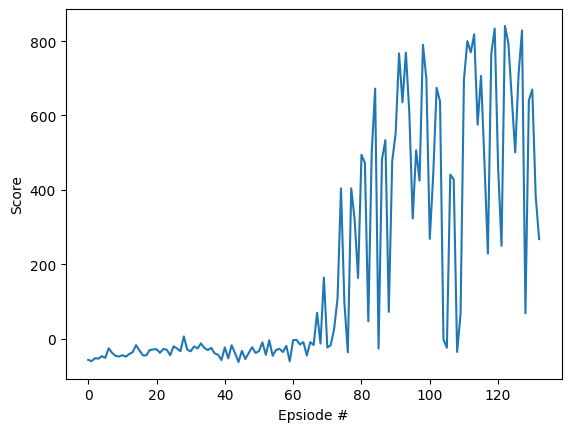

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(rewards)),rewards)
plt.ylabel('Score')
plt.xlabel('Epsiode #')
plt.show()

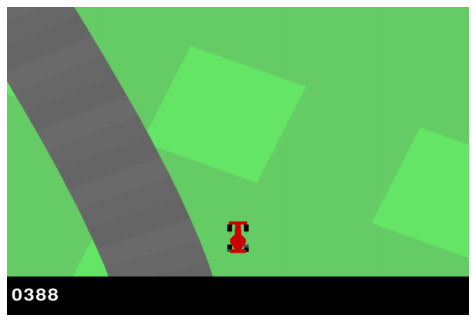

In [21]:
from matplotlib import animation

agent.qnetwork_target.load_state_dict(torch.load('./weights_best.pt'))

def save_frames_as_gif(frames, path='./CarRacing', filename='gym_animation_3.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=60)



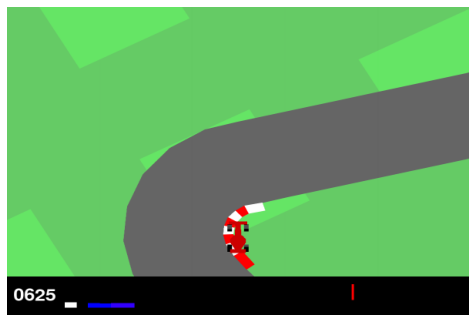

In [22]:
env2 = gym.make("CarRacing-v2",continuous=False, render_mode="rgb_array")

observation, _ = env2.reset()
frames = []
for t in range(1000):
    #Render to frames buffer
    frames.append(env2.render())
    action = agent.act(observation)
    observation, _, done, _, _ = env2.step(action)
    if done:
        break
env.close()
save_frames_as_gif(frames)